 # About

 This notebook shows a few examples of accessing and processing **QuimP** datafiles (*QCONF*) from Python. Similar
 approach is possible in every language that can read and process *json* files.

 Exemplary dataset *Stack.QCONF* obtained after full [QuimP
 pipeline](https://pilip.lnx.warwick.ac.uk/docs/develop/QuimP_Guide.html#x1-120007) (comprised of *BOA*, *ECMM*, *ANA*,
 *Q-Analysis* and *Protrusion Analysis* modules) is available in *data* folder.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import csv
try:
    # https://github.com/dunovank/jupyter-themes
    from jupyterthemes import jtplot
    jtplot.style(theme='grade3')
except ModuleNotFoundError:
    pass

 # Accessing QCONF data

 ## Loading QCONF files

 Assume that the whole pipeline has been run, so QCONF contains results of *ECMM*, *ANA* and *Q-Analysis*.
 The *QCONF* is a *json* file that represents internal (complicated) class structure of QuimP, which is partially
 depicted here:

 ![QCONF](https://pilip.lnx.warwick.ac.uk/site/apidocs/com/github/celldynamics/quimp/doc-files/datacontainer_UML.png)

 More details are available in [Java documentation](https://pilip.lnx.warwick.ac.uk/site/apidocs/index.html).

 For
 easier access we have created a helper function `it(jn, name, cellNo=0, fluoCh=0)` that contains paths of keys in
 json tree we
 need to traverse to get data. For example to retrieve *motility map* from *QCONF* for cell 0 we have to follow the
 path:

 ```python
 qconf['obj']['QState'][0]['motMap']
 ```

 Method `it` defines some shortcuts for most frequent data, so the above map can be easily obtained by calling
 `motility = it(dqconf, 'MOTMAP', cellNo=0)`.

In [2]:


def it(jn, name, cellNo=0, fluoCh=0):
    """
    Return value for given name from keyMap.

    Helper function to access values in QCONF.

    Args:
        jn:     json file (QCONF) as dict obtained from json.load(open('file'))
        name:   Predefined name from the keyMap.
        cellNo: number of cell (wherever it applies)
        fluoCh: fluorescence channel number (wherever it applies)

    Returns:
        Value for `name` key from QCONF (as Python datatype).

    """
    # This dict creates mapping between short convenient name and path of object names in json we have to traverse
    # to reach specified data.
    keyMap = {
        # date of creation of QCONF
        'QDATE': ['createdOn'],
        # absolute path to image (path from the system where QCONF was created)
        'QIMAGE': ['obj', 'BOAState', 'boap', 'orgFile', 'path'],
        'QFRAME': ['obj', 'BOAState', 'boap', 'FRAMES'],
        'QSNAKES': ['obj', 'BOAState', 'nest', 'sHs'],
        'FINALS': 'finalSnakes',
        'BOUNDS': 'bounds',
        'CENTROID': 'centroid',
        'QSTATE': ['obj', 'QState'],
        # int: time resolution of map
        'MAPT': ['obj', 'QState', f"{cellNo}", 'T'],
        # int: outline resolution of map
        'MAPR': ['obj', 'QState', f"{cellNo}", 'res'],
        # array[MAPT][MAPR]: motility map
        'MOTMAP': ['obj', 'QState', f"{cellNo}", 'motMap'],
        # array[MAPT][MAPR]: convexity map
        'CONMAP': ['obj', 'QState', f"{cellNo}", 'convMap'],
        # array[MAPT][MAPR]: fluorescence map
        'FLUMAP': ['obj', 'QState', f"{cellNo}", 'fluoMaps', f"{fluoCh}", 'map'],
        # bool: True if map enabled
        'FLUMAPSTATUS': ['obj', 'QState', f"{cellNo}", 'fluoMaps', f"{fluoCh}", 'enabled']
    }
    ans = jn
    keys = keyMap[name]
    # iterate over key tree towards data
    for k in keys:
        if k.isdigit():  # next object is list not class
            k = int(k)
        ans = ans[k]

    return ans



 ## Reading basic data from QCONF

 In this code we load experiment from *data* folder and display its properties. Then we load *motility*, *convexity*
 and *fluorescence* maps and convert them to `np.array` (by default map is read as Python datatype - `list[][]`).
 Note that this code assumes that those maps exists (so *Q-Analysis* has been run).
 Fluorescence maps can be stored in any (or all) of three channels (selected by user during *ANA* call). By default all
 channels contain empty (0-filled) arrays, therefore we look at `FLUMAPSTATUS` path to check which map has been
 generated on *ANA* call.


In [3]:
path = 'data/Stack.QCONF' if os.path.exists('data/Stack.QCONF') else '../data/Stack.QCONF'
cell = 0  # cell number

with open(path) as qconf:
    dqconf = json.load(qconf)
    # show some info
    print("*"*80)
    print("{} created at {}".format(os.path.basename(path), dqconf['createdOn']))
    print("Image: {}".format(it(dqconf, 'QIMAGE')))
    print("There are {} cells processed by Q-Analysis".format(len(it(dqconf, 'QSTATE'))))
    print(f"Maps for cell {cell}")
    print("\tMaps size [Frames x Points] {}x{}".format(it(dqconf, 'MAPT', cellNo=cell),
                                                       it(dqconf, 'MAPR', cellNo=cell)))
    # look for fluorescence map - find channels
    channels = []
    for i in range(3):  # there are 3 channels, look for bool: enabled field
        if it(dqconf, 'FLUMAPSTATUS', cellNo=cell, fluoCh=i):
            channels.append(i)
    print("\tFluorescence maps enabled for channels {}:".format(channels))
    print("*"*80)
    # load maps
    motility = np.array(it(dqconf, 'MOTMAP', cellNo=0))
    convexity = np.array(it(dqconf, 'CONMAP', cellNo=0))
    # get first available fluoMap
    fluo = np.array(it(dqconf, 'FLUMAP', cellNo=0, fluoCh=channels[0]))
    # load original image - QCONF stores full absolute path from the system where QCONF was created.
    # Ususally the image is in the same folder as QCONF.
    absImagePath = it(dqconf, 'QIMAGE')
    # resolve against QCONF location
    imagePath = os.path.join(os.path.relpath(os.path.dirname(absImagePath)), os.path.basename(absImagePath))
    image = io.imread(imagePath)
    print("Loaded stack {} {}".format(imagePath, image.shape))



********************************************************************************
Stack.QCONF created at Wed 2019.03.20 at 09:56:13 AM GMT
Image: /home/baniuk/Documents/Repos/QuimP-env/QuimP-Python/data/Stack.tif
There are 3 cells processed by Q-Analysis
Maps for cell 0
	Maps size [Frames x Points] 60x400
	Fluorescence maps enabled for channels [0]:
********************************************************************************
Loaded stack data/Stack.tif (60, 512, 512)


 ## Load tracks

 Track file is generated by Protrusion Analysis module and it is saved as a separate file (not as a part of QCONF)
 on each run. Its structure is like that:

 ```csv
 # Each tracked point has two tracks connected to it: backward and forward
 # Each track is defined by two coordinates: frame number and outline position
 # Numbers are indexes of maQP arrays that can be extracted from QCONF
 # by FormatConverter.
 Point 000 backward;[frame],24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
 Point 000 backward;[index],120,129,134,141,140,145,134,137,136,141,153,152,153,163,174,124,111,92,100,120,127,121,127,131
 Point 000 forward;[frame],24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
 Point 000 forward;[index],120,120,131,139,154,155,148,138,131,132,137,134,129,116,104,84,66,63,55,46,37,27,21,20,23,19,17,13,11,9,6,5,3,2,2
 Point 001 backward;[frame],37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
 Point 001 backward;[index],251,241,224,205,192,177,161,156,141,133,121,120,120,123,132,137,144,143,148,137,140,139,143,155,154,155,165,176,126,113,95,103,124,131,125,131,135
 Point 001 forward;[frame],37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
 Point 001 forward;[index],251,265,287,305,304,313,319,326,335,341,344,340,341,342,347,348,349,354,356,370,381,386
 ```
 Each tracked point is described by four lines, each two lines contain coordinates for backward and forward
 tracks respectively. The numbers are indices addressing any QuimP map (but only raw maps like those from QCONF or
  *maQP* files. Maps saved by *Q-Analysis* as *tiff* images are resized so can not be used with tracks. *maQP* files
 can be generated from QCONF by *Format Converter*). Maps and tracks can be used for many different purposes, e.g.
 one can plot local changes of motility|convexity|fluorescence along track (what stands for tracking particular point
 along time) or use *xMap* and *yMap* to convert from <frame;outline> space to Cartesian coordinates and plot tracks
 in original sequence (more details [here](https://pilip.lnx.warwick.ac.uk/docs/develop/QuimP_Guide.html#x1-3000013)).

 In code below we read *tracks.csv* file and convert it to `list[][]`, where first dimension is the number of
 tracked points * 4
 Note that tracked point (initial point we track in time) is repeated - it is first point of backward and forward track.

In [4]:
trackFile_path = 'data/tracks_0.csv' if os.path.exists('data/tracks_0.csv') else '../data/tracks_0.csv'
i_tracks = []  # indexes of tracks, [num_of_points*4][indexes]
with open(trackFile_path) as tracks:
    lines = csv.reader(tracks)
    for line in lines:
        if not line[0].startswith('#'):  # comment
            # reject first element which is Point number and convert to int
            i_tracks.append(list(map(int, line[1:])))
print("There are {} points in track file {}".format(len(i_tracks)//4, trackFile_path))


There are 3 points in track file data/tracks_0.csv


 # Examples

 Few examples how to process data read from QCONF and track file.

 ## Visualising maps

 Note that these maps are unscaled and in contrary to *tiff* images produced
 by *Q-Analysis* axes are not equal.
 We set aspect ratio for plots ratio to get square image

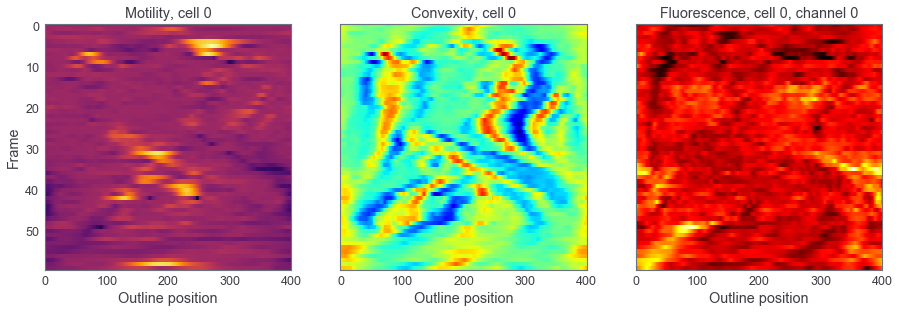

In [5]:
ratio = motility.shape[1]/motility.shape[0]
f, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 15))
ax[0].imshow(motility, aspect=ratio, cmap='inferno')
ax[0].set_title('Motility, cell {}'.format(cell))
ax[0].set_ylabel('Frame')
ax[1].imshow(convexity, aspect=ratio, cmap='jet')
ax[1].set_title('Convexity, cell {}'.format(cell))
ax[2].imshow(fluo, aspect=ratio, cmap='hot')
ax[2].set_title('Fluorescence, cell {}, channel {}'.format(cell, channels[0]))
for _ax in ax:
    _ax.set_xlabel('Outline position')
    _ax.grid(False)

 ## Visualising a value from map sampled along track

 Here is an example how to get motility for all tracked points along tracks.

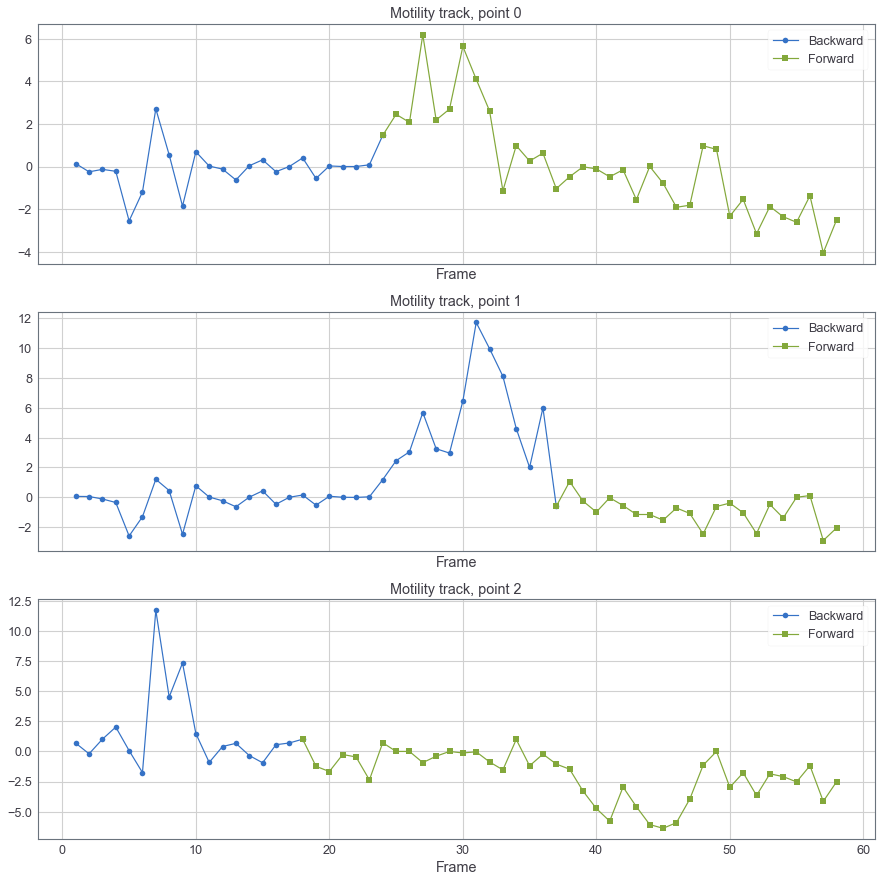

In [6]:
f, ax = plt.subplots(len(i_tracks)//4, 1, sharex=True, figsize=(15, 15))

for p in range(0, len(i_tracks), 4):  # over all points, p points to first line of each point (so step 4)
    # backward tracks are in reversed order and origin point is repeated in forward and backward
    back_frame = i_tracks[p][::-1]
    back_index = i_tracks[p+1][::-1]
    forw_frame = i_tracks[p+2]
    forw_index = i_tracks[p+3]
    mot_track_back = motility[back_frame, back_index]
    mot_track_forw = motility[forw_frame, forw_index]
    ax[p//4].plot(back_frame, mot_track_back, '-o')
    ax[p//4].plot(forw_frame, mot_track_forw, '-s')
    ax[p//4].set_title('Motility track, point {}'.format(p//4))

for _ax in ax:
    _ax.set_xlabel('Frame')
    _ax.legend(('Backward', 'Forward'))


 ## Visualising tracks

 Another example how to create more sophisticated plots.

Text(0.5, 1.0, 'Fluorescence along track')

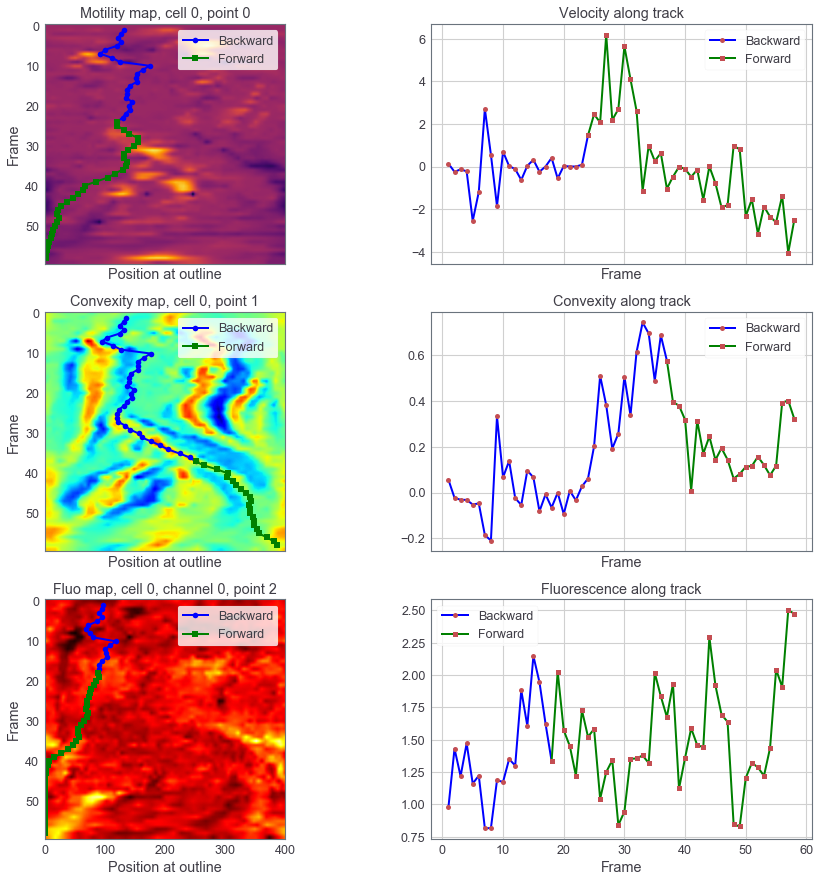

In [7]:


def plotMapWithTracks(ax, qmap, p, tracks, plot_on_map, **kwargs):
    """
    Plot tracks or specified map with tracks overlayed.

    Args:
        ax:     axis handle to plot in
        qmap:   map to plot
        p:      number of tracked point
        tracks: list of tracks read from tracks.csv file (as specified above)
        plot_on_map: If True plot track on map, otherwise plot values of qmap along track

    Returns:
    ax: Axis handle
    """
    back_frame = tracks[p*4][::-1]
    back_index = tracks[p*4+1][::-1]
    forw_frame = tracks[p*4+2]
    forw_index = tracks[p*4+3]
    if plot_on_map:
        ax.imshow(qmap, interpolation='bilinear', **kwargs)
        ax.plot(back_index, back_frame, linewidth=2, color='blue', marker='o')
        ax.plot(forw_index, forw_frame, linewidth=2, color='green', marker='s')
        ax.grid(False)
        ax.set_xlabel("Position at outline")
        ax.set_ylabel("Frame")
    else:
        val_track_back = qmap[back_frame, back_index]
        val_track_forw = qmap[forw_frame, forw_index]
        ax.plot(back_frame, val_track_back, linewidth=2, color='blue',
                marker='o', markerfacecolor='r', markeredgecolor='k', ms=5)
        ax.plot(forw_frame, val_track_forw, linewidth=2, color='green',
                marker='s', markerfacecolor='r', markeredgecolor='k', ms=5)
        ax.set_xlabel('Frame')
    ax.legend(('Backward', 'Forward'))
    return ax


f, ax = plt.subplots(3, 2, sharex='col', figsize=(15, 15))
p = 0  # point to plot
plotMapWithTracks(ax[0, 0], motility, p, i_tracks, True, aspect=ratio,
                  cmap='inferno').set_title("Motility map, cell {}, point {}".format(cell, p))
plotMapWithTracks(ax[0, 1], motility, p, i_tracks, False).set_title("Velocity along track")

p = 1  # point to plot
plotMapWithTracks(ax[1, 0], convexity, p, i_tracks, True, aspect=ratio,
                  cmap='jet').set_title("Convexity map, cell {}, point {}".format(cell, p))
plotMapWithTracks(ax[1, 1], convexity, p, i_tracks, False).set_title("Convexity along track")

p = 2  # point to plot
plotMapWithTracks(ax[2, 0], fluo, p, i_tracks, True, aspect=ratio, cmap='hot').set_title(
    "Fluo map, cell {}, channel {}, point {}".format(cell, channels[0], p))
plotMapWithTracks(ax[2, 1], fluo, p, i_tracks, False).set_title("Fluorescence along track")

